In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import pystan
import fbprophet 
import plotly 



#built-in 
import datetime

print('pandas ==',pd.__version__)
print('numpy ==',np.__version__)
print('matplotlib ==',matplotlib.__version__)
print('seaborn ==',sns.__version__)
print('plotly ==', plotly.__version__)
print('pystan ==',pystan.__version__)
print('fbprophet ==',fbprophet.__version__)

pandas == 1.2.2
numpy == 1.19.2
matplotlib == 3.3.4
seaborn == 0.11.1
pystan == 2.19.1.1
fbprophet == 0.7.1


# Funções

In [2]:
# =======================================================================================
## FUNÇÕES PARA A IMPORTAÇÃO DOS DADOS E TRANSFORMAR DATAS

def converte_variaveis_em_datas(dataframe):
    for variavel in dataframe.columns:
        if 'DATA' in variavel:
            try:
                dataframe[variavel] = pd.to_datetime(dataframe[variavel], format='%d/%m/%Y')
            
            except:
                print(f'Variável "{variavel}" contém um erro e conversão/formatação')
                pass
        else:
            pass 
    return dataframe


def tira_variaveis_IBGE(dataframe):
    dataframe = dataframe.drop(['IBGE_RES_PR','IBGE_ATEND_PR'], axis='columns')
    return dataframe


def cria_variavel_caso_confirmado_no_dia(dataframe):
    dataframe['CASO_CONFIRMADO_NO_DIA'] = 1
    return dataframe


def replace_nas_variaveis_obito_status(dataframe):

    dataframe['OBITO'] = dataframe['OBITO'].replace('SIM','Sim')
    dataframe['OBITO'] = dataframe['OBITO'].replace('Não','Nao')

    dataframe['OBITO'] = dataframe['OBITO'].replace('Sim',1)
    dataframe['OBITO'] = dataframe['OBITO'].replace('Nao',0)

    dataframe['STATUS'] = dataframe['STATUS'].replace('Recuperado','recuperado')
    dataframe['STATUS'] = dataframe['STATUS'].replace('recuperado', 1)
    dataframe['STATUS'] = dataframe['STATUS'].replace('nan', 0)

    return dataframe
    

def pre_processamento(dataframe):
    dataframe = converte_variaveis_em_datas(dataframe)
    dataframe = tira_variaveis_IBGE(dataframe)
    dataframe = cria_variavel_caso_confirmado_no_dia(dataframe)
    dataframe = replace_nas_variaveis_obito_status(dataframe)
    dataframe = dataframe.set_index('DATA_CONFIRMACAO_DIVULGACAO')
    dataframe = dataframe.sort_index()
    return dataframe

def baixa_base_de_dados_casos_gerais(ano,mes,dia):
    """
    Esta função baixa a base de dados disponível no ano, mes e dia.
    retorna um dataframe do pandas com os dados disponpiveis.
    """
    data = datetime.date(ano, mes, dia)
    ano = str(data.year)

    if mes != 10 and mes != 11 and mes != 12:
        mes = '0'+str(data.month)
    else:
        mes = str(data.month)

    if dia in [1,2,3,4,6,7,8,9]:
        dia = '0'+str(data.day)

    ano_mes = ano+'-'+mes

    if ano == '2020':
        arquivo = f'INFORME_EPIDEMIOLOGICO_{dia}_{mes}_GERAL.csv'
    elif ano == '2021':
        arquivo = f'informe_epidemiologico_{dia}_{mes}_{ano}_geral.csv'
    # Podem acontecer as seguintes variações no site do estado:
    # informe_epidemiologico_{dia}_{mes}_{ano}_geral.csv
    # informe_epidemiologico_{dia}_{mes}_geral.csv
    # INFORME_EPIDEMIOLOGICO_{dia}_{mes}_GERAL.csv



    dominio = 'https://www.saude.pr.gov.br'
    caminho = f'/sites/default/arquivos_restritos/files/documento/{ano_mes}/'
    try:

        url = dominio+caminho+arquivo
        base_de_dados = pd.read_csv(url, sep=';')
        base_de_dados = pre_processamento(base_de_dados)
        
    
    except:
        raise Exception('Não Tem dados disponíveis neste dia.')

    return base_de_dados

# =======================================================================================
## FUNÇÕES PARA SELEÇÃO 

def seleciona_media_movel(dataframe):

    if 'MUN_ATENDIMENTO' in dataframe.columns and 'DATA_CONFIRMACAO_DIVULGACAO' in dataframe.columns:
        dataframe = dataframe.groupby(['MUN_ATENDIMENTO','DATA_CONFIRMACAO_DIVULGACAO'])[['CASO_CONFIRMADO_NO_DIA','OBITO']].sum().rolling(15).mean()[15:]
        return dataframe
    else:
        raise Exception('')




# Importando os Dados 

In [60]:

informe_covid.columns

Index(['SEXO', 'IDADE_ORIGINAL', 'MUN_RESIDENCIA', 'MUN_ATENDIMENTO',
       'LABORATORIO', 'DATA_DIAGNOSTICO', 'DATA_INICIO_SINTOMAS', 'OBITO',
       'DATA_OBITO', 'DATA_OBITO_DIVULGACAO', 'STATUS',
       'DATA_RECUPERADO_DIVULGACAO', 'FONTE_DADO_RECUPERADO',
       'CASO_CONFIRMADO_NO_DIA'],
      dtype='object')

In [59]:
if 'DATA_CONFIRMACAO_DIVULGACAO' in informe_covid.columns:
    print(True)

In [4]:
hoje = datetime.date.today()
informe_covid = baixa_base_de_dados_casos_gerais(hoje.year, hoje.month, hoje.day - 2)

Variável "DATA_INICIO_SINTOMAS" contém um erro e conversão/formatação


In [5]:
informe_covid

,SEXO,IDADE_ORIGINAL,MUN_RESIDENCIA,MUN_ATENDIMENTO,LABORATORIO,DATA_DIAGNOSTICO,DATA_INICIO_SINTOMAS,OBITO,DATA_OBITO,DATA_OBITO_DIVULGACAO,STATUS,DATA_RECUPERADO_DIVULGACAO,FONTE_DADO_RECUPERADO,CASO_CONFIRMADO_NO_DIA
DATA_CONFIRMACAO_DIVULGACAO,,,,,,,,,,,,,,
2020-03-12,F,26,CURITIBA,CURITIBA,Genoprimer,2020-03-18,15/03/2020,0.0,NaT,NaT,1.0,NaT,NaN,1
2020-03-12,F,47,CIANORTE,CIANORTE,LACEN,2020-03-12,NaN,0.0,NaT,NaT,1.0,NaT,Notificações,1
2020-03-12,F,26,CURITIBA,CURITIBA,Genoprimer,2020-03-16,11/03/2020,0.0,NaT,NaT,1.0,NaT,NaN,1
2020-03-12,M,15,CURITIBA,CURITIBA,LACEN,2020-03-12,08/03/2020,0.0,NaT,NaT,1.0,NaT,NaN,1
2020-03-12,M,28,SAO PAULO/SP,CURITIBA,Genoprimer,2020-03-16,NaN,0.0,NaT,NaT,1.0,2020-08-05,SMS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-07,F,96,CURITIBA,NaN,Não informado,2021-01-13,11/01/2021,NaN,NaT,NaT,NaN,NaT,NaN,1
2021-03-07,F,41,CURITIBA,CURITIBA,"COVID-19, Biologia Molecular",2020-08-10,NaN,NaN,NaT,NaT,NaN,NaT,NaN,1
2021-03-07,F,71,CAMPO LARGO,CAMPO LARGO,"COVID-19, Biologia Molecular",2021-03-05,25/02/2021,NaN,NaT,NaT,NaN,NaT,NaN,1


In [70]:
def seleciona_cidade(cidade, dataframe):
    """
    Esta função retona todos os registros
    cujo o atendimento ocorreu na cidade 
    passada como parâmetro.
    Retorna um dataframe.
    """
    dados_cidade = dataframe.query(f'MUN_ATENDIMENTO == "{cidade.upper()}"')
    return dados_cidade.reset_index()



In [85]:
move_average_15_por_cidade = informe_covid.groupby(['MUN_ATENDIMENTO','DATA_CONFIRMACAO_DIVULGACAO'])[['CASO_CONFIRMADO_NO_DIA','OBITO']].sum().rolling(15).mean()[15:].round()

In [86]:
move_average_15_por_cidade.to_csv('../dados_recentes/cidades_mm15.csv', sep=';')

In [46]:
move_average_15_por_cidade.index

MultiIndex([('ABATIA', '2020-07-02'),
            ('ABATIA', '2020-07-03'),
            ('ABATIA', '2020-07-07'),
            ('ABATIA', '2020-07-08'),
            ('ABATIA', '2020-07-13'),
            ('ABATIA', '2020-07-15'),
            ('ABATIA', '2020-07-21'),
            ('ABATIA', '2020-08-22'),
            ('ABATIA', '2020-08-27'),
            ('ABATIA', '2020-08-29'),
            ...
            ('XAMBRE', '2021-02-04'),
            ('XAMBRE', '2021-02-15'),
            ('XAMBRE', '2021-02-17'),
            ('XAMBRE', '2021-02-19'),
            ('XAMBRE', '2021-02-21'),
            ('XAMBRE', '2021-02-26'),
            ('XAMBRE', '2021-02-27'),
            ('XAMBRE', '2021-03-02'),
            ('XAMBRE', '2021-03-04'),
            ('XAMBRE', '2021-03-07')],
           names=['MUN_ATENDIMENTO', 'DATA_CONFIRMACAO_DIVULGACAO'], length=50422)

('ABATIA', Timestamp('2020-07-02 00:00:00'))

## Não vai ter como upar todos os dados, vai ser necessário realizar uma média móvel para a exibir os dados. 

In [72]:
dados_pg = seleciona_cidade('PONTA GROSSA', move_average_15_por_cidade)

<AxesSubplot:xlabel='DATA_CONFIRMACAO_DIVULGACAO', ylabel='CASO_CONFIRMADO_NO_DIA'>

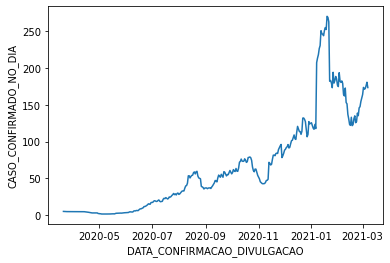

In [74]:
sns.lineplot(data=dados_pg, x='DATA_CONFIRMACAO_DIVULGACAO',y='CASO_CONFIRMADO_NO_DIA')

In [89]:
medias_moveis = pd.read_csv('https://raw.githubusercontent.com/ConradBitt/covid_parana/main/dados_recentes/cidades_mm15.csv', sep=';')

In [91]:
medias_moveis.query('MUN_ATENDIMENTO == "PONTA GROSSA"')

,MUN_ATENDIMENTO,DATA_CONFIRMACAO_DIVULGACAO,CASO_CONFIRMADO_NO_DIA,OBITO
35502,PONTA GROSSA,2020-03-21,5.0,0.0
35503,PONTA GROSSA,2020-03-25,5.0,0.0
35504,PONTA GROSSA,2020-04-04,5.0,0.0
35505,PONTA GROSSA,2020-04-14,5.0,0.0
35506,PONTA GROSSA,2020-04-18,4.0,0.0
...,...,...,...,...
35809,PONTA GROSSA,2021-03-03,171.0,3.0
35810,PONTA GROSSA,2021-03-04,172.0,2.0
35811,PONTA GROSSA,2021-03-05,176.0,2.0
35812,PONTA GROSSA,2021-03-06,181.0,2.0


In [92]:
cidades = medias_moveis.MUN_ATENDIMENTO.unique()

In [95]:
!pip install plotly

     |████████████████████████████████| 13.2 MB 196 kB/s 
  Using cached retrying-1.3.3.tar.gz (10 kB)
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=b5891a335f4019c9b3b908b25da04d6f0a8dcecfdad6ca94867bbe82a3c4d4b1
  Stored in directory: /home/conrado/.cache/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [97]:
import plotly 

print('plotly==', plotly.__version__)

plotly== 4.11.0


In [ ]:
import plotly.express as px 

fig = px.line(medias_moveis, )